# SPS MBA Dipole -- CS Segment Harmonic Analysis

**Measurement session:** `20251212_171026_SPS_MBA`
**Segment:** CS
**Magnet:** MBA (normal dipole, m=1)
**Kn calibration:** AC compensation (`Kn_values_Seg_Main_A_AC.txt`)
**Drift correction:** Both **legacy** (C++ compatible) and **weighted** (Bottura/Pentella) modes

| Section | Content |
|---------|----------|
| 1 | Configuration & imports |
| 2 | Kn calibration (AC compensation) |
| 3 | Measurement data discovery |
| 4 | Pipeline processing -- legacy & weighted drift |
| 5 | Main field (B1) overview |
| 6 | Drift correction comparison |
| 7 | b3 (sextupole) deep dive: overview, hysteresis, drift modes, reproducibility |
| 8 | Summary & export |

## AC compensation & channel merge

AC compensation suppresses the dipole (n=1) sensitivity in the compensated
channel, giving a much cleaner extraction of higher-order harmonics. The merge
strategy is **abs for n<=m, cmp for n>m** (`abs_upto_m_cmp_above`).

## Current levels & 0 A exclusion

The measurement ramps from 0 A to ~1400 A and back. At 0 A the main
dipole field is at noise level, making normalised harmonics
b_n = C_n / C_m x 10000 meaningless. **0 A is excluded** from all
quantitative analysis. Statistics are reported per discrete current level.

---
## 1. Configuration & Imports

In [1]:
# === CONFIGURATION ===
SEGMENT = "CS"

SESSION = "20251212_171026_SPS_MBA"
MEAS_SUBDIR = "20251212_171620_MBA"
KN_SUBPATH = "CRMMMMH_AV-00000001/Kn_values_Seg_Main_A_AC.txt"

MAGNET_ORDER = 1          # dipole
R_REF = 0.02              # reference radius [m]
L_COIL = 0.47             # coil length [m]
SAMPLES_PER_TURN = 1024   # encoder samples per revolution

# Pipeline options: drift + rotation + center-location + feeddown
# (no 'dit' -- plateau measurements have constant current, di/dt ~ 0)
# (no 'nor' -- normalisation done manually after merge)
OPTIONS = ("dri", "rot", "cel", "fed")

# Minimum |B1| for normalisation (avoid division by noise)
MIN_B1_T = 1e-4

print(f"SPS MBA Dipole -- {SEGMENT} Segment Harmonic Analysis")
print("=" * 50)
print(f"  Segment       : {SEGMENT}")
print(f"  Session       : {SESSION}")
print(f"  Kn file       : {KN_SUBPATH.split('/')[-1]}")
print(f"  Magnet order  : {MAGNET_ORDER} (dipole)")
print(f"  R_ref         : {R_REF} m")
print(f"  L_coil        : {L_COIL} m")
print(f"  Samples/turn  : {SAMPLES_PER_TURN}")
print(f"  Options       : {OPTIONS}")

SPS MBA Dipole -- CS Segment Harmonic Analysis
  Segment       : CS
  Session       : 20251212_171026_SPS_MBA
  Kn file       : Kn_values_Seg_Main_A_AC.txt
  Magnet order  : 1 (dipole)
  R_ref         : 0.02 m
  L_coil        : 0.47 m
  Samples/turn  : 1024
  Options       : ('dri', 'rot', 'cel', 'fed')


In [ ]:
import sys
from pathlib import Path
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams.update({
    "figure.figsize": (12, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "figure.dpi": 100,
})

# Add repo root to path
repo_root = Path("../..").resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from rotating_coil_analyzer.analysis.kn_pipeline import (
    load_segment_kn_txt,
)
from rotating_coil_analyzer.analysis.utility_functions import (
    process_kn_pipeline,
    build_harmonic_rows,
    build_run_averages,
)
from rotating_coil_analyzer.ingest.channel_detect import robust_range

print("Imports ready.")

In [3]:
# Repo root -- walk up from CWD until we find pyproject.toml or .git
REPO_ROOT = Path(".").resolve()
while REPO_ROOT != REPO_ROOT.parent:
    if (REPO_ROOT / "pyproject.toml").exists() or (REPO_ROOT / ".git").exists():
        break
    REPO_ROOT = REPO_ROOT.parent

SESSION_DIR = REPO_ROOT / "measurements" / SESSION
RUN_DIR = SESSION_DIR / MEAS_SUBDIR

# Kn calibration file
KN_PATH = SESSION_DIR / KN_SUBPATH

print(f"Repo root   : {REPO_ROOT}")
print(f"Session dir : {SESSION_DIR}")
print(f"Run dir     : {RUN_DIR}")
print(f"Kn file     : {KN_PATH}")
assert KN_PATH.exists(), f"Kn file not found: {KN_PATH}"

Repo root   : C:\Users\albellel\python-projects\rotating-coil-analyzer
Session dir : C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\20251212_171026_SPS_MBA
Run dir     : C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\20251212_171026_SPS_MBA\20251212_171620_MBA
Kn file     : C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\20251212_171026_SPS_MBA\CRMMMMH_AV-00000001\Kn_values_Seg_Main_A_AC.txt


---
## 2. Kn Calibration (AC Compensation)

In [4]:
# Load Kn calibration
kn = load_segment_kn_txt(str(KN_PATH))
H = len(kn.orders)

print(f"Kn: {H} harmonics from {KN_PATH.name}")
print(f"  Orders: {list(kn.orders)}")

# Show absolute vs compensated sensitivity for main field
kn_abs_n1 = abs(kn.kn_abs[0])
kn_cmp_n1 = abs(kn.kn_cmp[0])
ratio_n1 = kn_abs_n1 / max(kn_cmp_n1, 1e-30)

print(f"\n  |Kn_abs(n=1)| = {kn_abs_n1:.6e}")
print(f"  |Kn_cmp(n=1)| = {kn_cmp_n1:.6e}")
print(f"  Abs/Cmp suppression ratio (n=1): {ratio_n1:.0f}x")

Kn: 15 harmonics from Kn_values_Seg_Main_A_AC.txt
  Orders: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15)]

  |Kn_abs(n=1)| = 1.154364e-01
  |Kn_cmp(n=1)| = 5.695530e-06
  Abs/Cmp suppression ratio (n=1): 20268x


---
## 3. Measurement Data Discovery

In [ ]:
FILE_PAT = re.compile(
    r"Run_(\d+)_I_([\d.]+)A_(N?CS)_raw_measurement_data\.txt$"
)

all_run_files = []
for f in sorted(RUN_DIR.iterdir()):
    m = FILE_PAT.search(f.name)
    if m:
        all_run_files.append((
            int(m.group(1)),     # run index
            float(m.group(2)),   # nominal current (A)
            m.group(3),          # segment: CS or NCS
            f,                   # full path
        ))

# Filter to CS segment only
run_files = [r for r in all_run_files if r[2] == SEGMENT]

I_range = (min(r[1] for r in run_files), max(r[1] for r in run_files))

print(f"Found {len(all_run_files)} total raw files")
print(f"Filtered to {SEGMENT}: {len(run_files)} files")
print(f"  Current range: {I_range[0]:.0f} .. {I_range[1]:.0f} A")

# Determine channel assignment from a high-current file
sample_file = next(r[3] for r in run_files if r[1] > 500)
sample_raw = np.loadtxt(sample_file)

r1 = robust_range(sample_raw[:, 1])
r2 = robust_range(sample_raw[:, 2])
SWAP_FLUX = (r2 > r1)
COL_ABS = 2 if SWAP_FLUX else 1
COL_CMP = 1 if SWAP_FLUX else 2

# Current column: pick by largest robust range among columns 3+
ncols = sample_raw.shape[1]
curr_ranges = [(robust_range(sample_raw[:, c]), c) for c in range(3, ncols)]
curr_ranges.sort(key=lambda x: -x[0])
COL_I = curr_ranges[0][1]

print(f"\nChannel assignment (from {sample_file.name}):")
print(f"  Flux col {COL_ABS} -> abs (range={r1 if not SWAP_FLUX else r2:.4e})")
print(f"  Flux col {COL_CMP} -> cmp (range={r2 if not SWAP_FLUX else r1:.4e})")
print(f"  Current col {COL_I} (range={curr_ranges[0][0]:.2f})")
if SWAP_FLUX:
    print("  NOTE: flux columns swapped (col2 > col1 by robust range)")

---
## 4. Pipeline Processing -- Legacy & Weighted Drift

In [ ]:
Ns = SAMPLES_PER_TURN
m = MAGNET_ORDER

# Maximum |zR| (center offset / R_ref) for CEL.  For dipoles with AC
# compensation the CEL uses compensated-channel harmonics n=10,11 which
# are at noise level.  A tight threshold prevents the feeddown Taylor
# expansion from amplifying that noise into the merged harmonics.
# 0.01 corresponds to 0.2 mm at R_ref = 0.02 m.
MAX_ZR = 0.01

def process_file(path, drift_mode):
    """Process one raw file through the full kn pipeline.

    Returns list of per-turn row dicts, or empty list on failure.
    """
    raw = np.loadtxt(path)
    n_total = raw.shape[0]
    n_turns = n_total // Ns
    if n_turns == 0:
        return []
    n_keep = n_turns * Ns
    shape = (n_turns, Ns)

    t_arr = raw[:n_keep, 0].reshape(shape)
    df_abs = raw[:n_keep, COL_ABS].reshape(shape)
    df_cmp = raw[:n_keep, COL_CMP].reshape(shape)
    I_arr = raw[:n_keep, COL_I].reshape(shape)

    result, C_merged, C_units, ok_main = process_kn_pipeline(
        flux_abs_turns=df_abs,
        flux_cmp_turns=df_cmp,
        t_turns=t_arr,
        I_turns=I_arr,
        kn=kn,
        r_ref=R_REF,
        magnet_order=m,
        options=OPTIONS,
        drift_mode=drift_mode,
        min_b1_T=MIN_B1_T,
        max_zr=MAX_ZR,
    )

    extra = [{"turn_in_run": t} for t in range(n_turns)]
    return build_harmonic_rows(result, C_merged, C_units, ok_main, m, extra)


# --- Main processing loop (CS segment only) ---
rows_legacy = []
rows_weighted = []
n_failed = 0

for run_idx, I_nom, seg, path in run_files:
    for drift_mode, target in [("legacy", rows_legacy), ("weighted", rows_weighted)]:
        try:
            rows = process_file(path, drift_mode)
            for row in rows:
                row["run"] = run_idx
                row["segment"] = seg
                row["I_nom_A"] = I_nom
            target.extend(rows)
        except Exception as exc:
            if drift_mode == "legacy":  # only count once
                n_failed += 1
                print(f"  SKIP {path.name}: {exc}")

df_L = pd.DataFrame(rows_legacy)
df_W = pd.DataFrame(rows_weighted)

for label, df in [("Legacy", df_L), ("Weighted", df_W)]:
    print(f"{label:>10s}: {len(df)} turns from "
          f"{df['run'].nunique()} runs ({SEGMENT} segment)")
if n_failed:
    print(f"  Failed: {n_failed} files")
print(f"\nHarmonics: n=1..{H}")
print(f"Current range: {df_L['I_mean_A'].min():.1f} .. {df_L['I_mean_A'].max():.1f} A")

# Diagnostic: how many turns have valid main field?
n_ok = df_L["ok_main"].sum()
n_total_turns = len(df_L)
print(f"\nNormalization diagnostics:")
print(f"  Turns with |B1| > {MIN_B1_T} T (ok_main=True): {n_ok} / {n_total_turns}")
print(f"  Turns with weak B1 (ok_main=False): {n_total_turns - n_ok} / {n_total_turns}")
print(f"  max_zR = {MAX_ZR} (center offset clamp for CEL)")
b1_vals = df_L["B1_T"].values
b1_finite = b1_vals[np.isfinite(b1_vals)]
if len(b1_finite) > 0:
    print(f"  B1 range (all finite): [{b1_finite.min():.6e}, {b1_finite.max():.6e}] T")
else:
    print(f"  WARNING: No finite B1 values found!")

In [7]:
# --- Discover current levels and set up per-level masks ---
# Use legacy DataFrame as reference (both have identical I values)
I_nom_all = df_L["I_nom_A"].values
I_rounded = np.round(I_nom_all).astype(int)

current_levels = sorted(set(I_rounded))
nonzero_levels = [lv for lv in current_levels if lv != 0]
nonzero_mask = I_rounded != 0

print(f"Current levels ({len(current_levels)}): {current_levels}")
print(f"Non-zero levels ({len(nonzero_levels)}): {nonzero_levels}")
print(f"0 A turns (excluded): {(~nonzero_mask).sum()}")
print(f"Non-zero turns: {nonzero_mask.sum()}")
print(f"\n  {SEGMENT}: {len(df_L)} turns, {df_L['run'].nunique()} runs")

Current levels (63): [np.int64(0), np.int64(50), np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300), np.int64(350), np.int64(400), np.int64(450), np.int64(500), np.int64(550), np.int64(600), np.int64(650), np.int64(700), np.int64(750), np.int64(800), np.int64(850), np.int64(900), np.int64(950), np.int64(1000), np.int64(1050), np.int64(1100), np.int64(1150), np.int64(1200), np.int64(1250), np.int64(1300), np.int64(1350), np.int64(1400), np.int64(1450), np.int64(1500), np.int64(1550), np.int64(1600), np.int64(1650), np.int64(1700), np.int64(1750), np.int64(1800), np.int64(1850), np.int64(1900), np.int64(1950), np.int64(2000), np.int64(2050), np.int64(2100), np.int64(2150), np.int64(2200), np.int64(2250), np.int64(2300), np.int64(2350), np.int64(2400), np.int64(2450), np.int64(2500), np.int64(2550), np.int64(2600), np.int64(2650), np.int64(2700), np.int64(2750), np.int64(2800), np.int64(2850), np.int64(2900), np.int64(2950), np.int64(3000), np.int64(3050), np.int64(

---
## 5. Main Field (B1) Overview

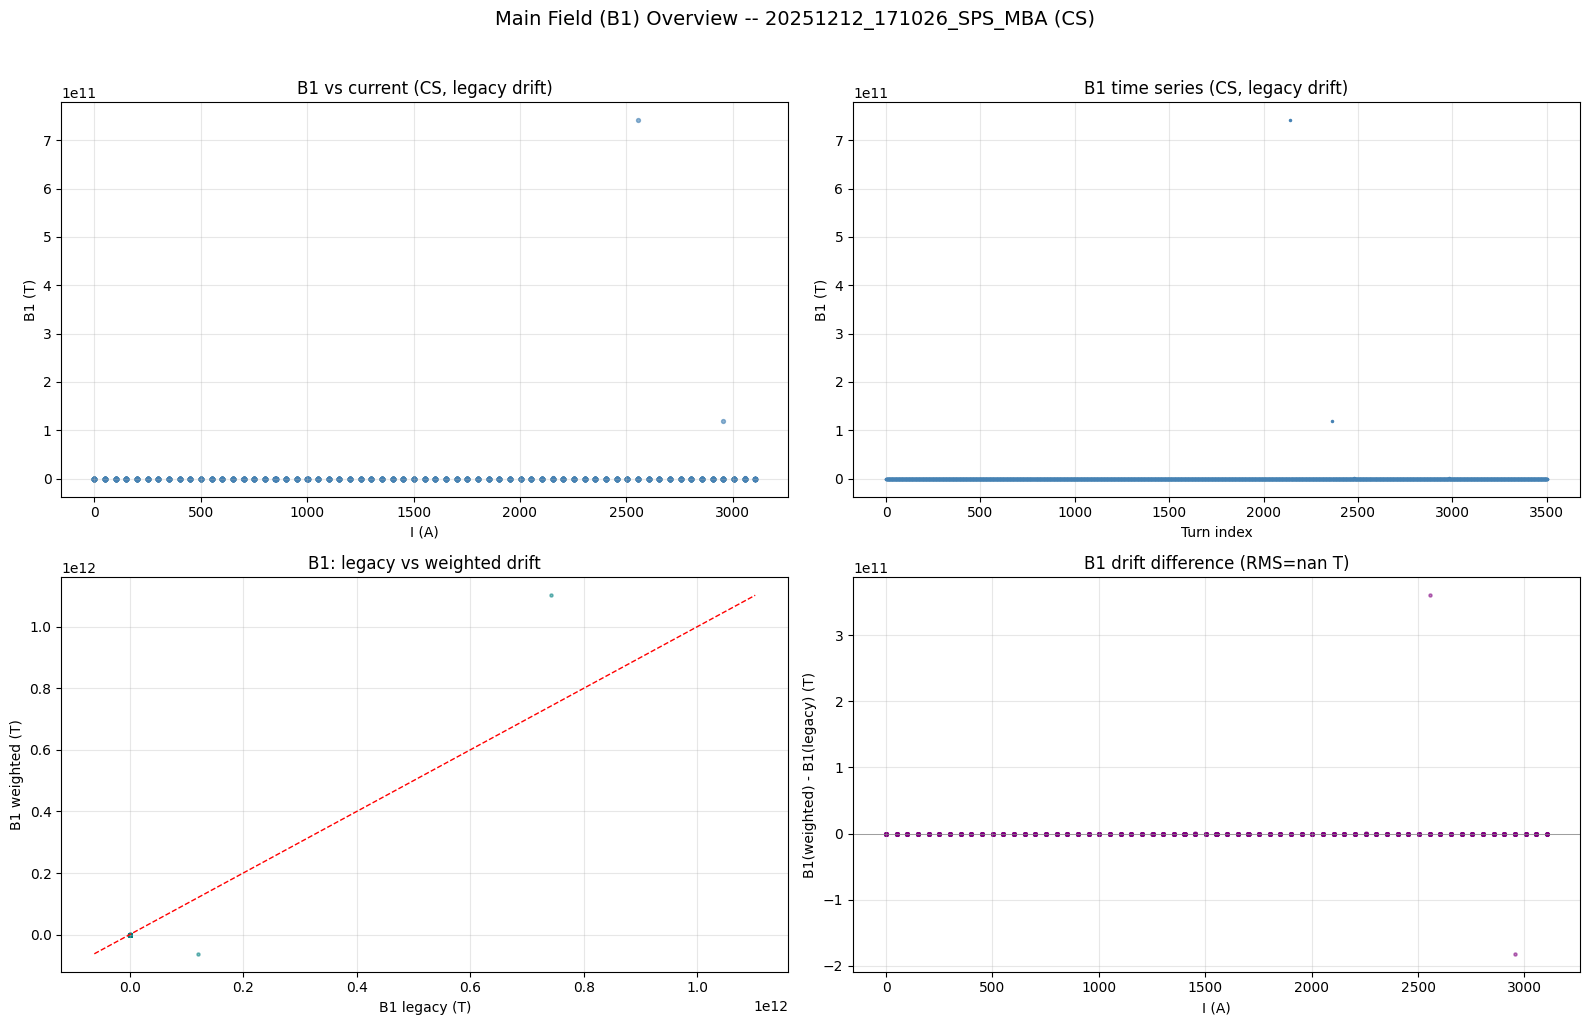


B1 Summary (legacy drift):
  Range : [-339954893.048499, 741430035485.576050] T
  At max current: B1 = 1.191440 T
  Legacy vs weighted RMS diff: nan T


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (a) B1 vs current (legacy)
ax = axes[0, 0]
ax.scatter(df_L["I_mean_A"], df_L["B1_T"],
           s=8, alpha=0.6, color="steelblue")
ax.set_xlabel("I (A)")
ax.set_ylabel("B1 (T)")
ax.set_title(f"B1 vs current ({SEGMENT}, legacy drift)")

# (b) B1 vs time -- sequential turn index (legacy)
ax = axes[0, 1]
ax.plot(df_L["B1_T"].values, ".", markersize=3, color="steelblue")
ax.set_xlabel("Turn index")
ax.set_ylabel("B1 (T)")
ax.set_title(f"B1 time series ({SEGMENT}, legacy drift)")

# (c) B1 legacy vs weighted
ax = axes[1, 0]
ax.scatter(df_L["B1_T"], df_W["B1_T"], s=5, alpha=0.5, c="teal")
lims = [min(df_L["B1_T"].min(), df_W["B1_T"].min()),
        max(df_L["B1_T"].max(), df_W["B1_T"].max())]
ax.plot(lims, lims, "r--", linewidth=1)
ax.set_xlabel("B1 legacy (T)")
ax.set_ylabel("B1 weighted (T)")
ax.set_title("B1: legacy vs weighted drift")

# (d) B1 difference (weighted - legacy) vs current
ax = axes[1, 1]
b1_diff = df_W["B1_T"].values - df_L["B1_T"].values
ax.scatter(df_L["I_mean_A"], b1_diff, s=5, alpha=0.5, c="purple")
ax.axhline(0, color="grey", linewidth=0.5)
ax.set_xlabel("I (A)")
ax.set_ylabel("B1(weighted) - B1(legacy) (T)")
ax.set_title(f"B1 drift difference (RMS={np.sqrt(np.mean(b1_diff**2)):.4e} T)")

fig.suptitle(f"Main Field (B1) Overview -- {SESSION} ({SEGMENT})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# B1 summary
print("\nB1 Summary (legacy drift):")
print(f"  Range : [{df_L['B1_T'].min():.6f}, {df_L['B1_T'].max():.6f}] T")
print(f"  At max current: B1 = {df_L.loc[df_L['I_mean_A'].idxmax(), 'B1_T']:.6f} T")
print(f"  Legacy vs weighted RMS diff: {np.sqrt(np.mean(b1_diff**2)):.4e} T")

---
## 6. Drift Correction Comparison

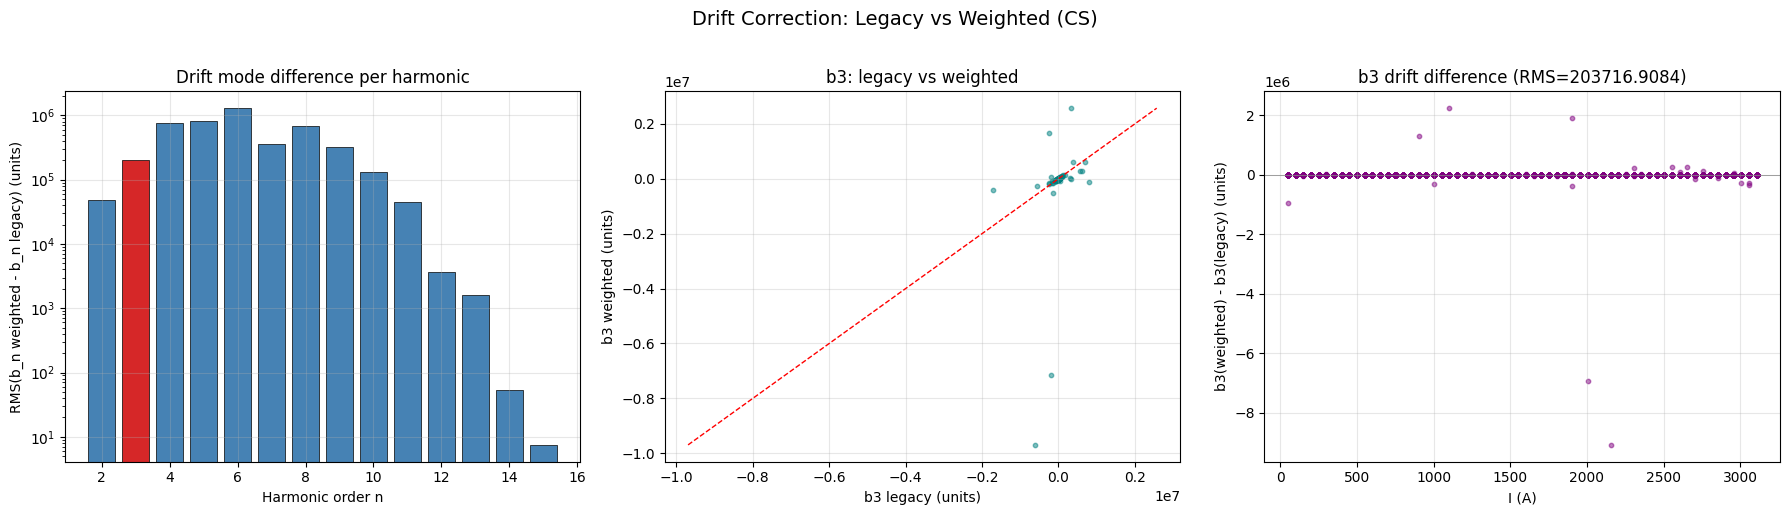


Drift comparison per harmonic (CS, non-zero current, units):
   n      mean(L)      mean(W)    mean diff     RMS diff   max |diff|
--------------------------------------------------------------------------------
   2    +181.5722    -622.5353  -804.107526 47691.635135 2578667.530286
   3    -329.6963   -3891.3137 -3561.617399 203716.908425 9087245.014813 <-- b3
   4    -404.9258   -1215.6598  -810.734029 749000.726697 31412531.607984
   5     +78.5398   -7714.8005 -7793.340317 801859.606535 45285266.048881
   6   -2341.2046  -34517.4588 -32176.254186 1290700.810498 66927619.960400
   7   +2389.2931    +223.9868 -2165.306283 358670.725744 16962884.533454
   8    -131.5533  +14149.1915 +14280.744808 691106.838981 37623887.442012
   9    -260.4920   -3462.5245 -3202.032517 318163.949297 14212702.696173
  10    +288.9790    -370.9673  -659.946392 130381.247180 5843538.427586
  11     -23.5559    +982.4853 +1006.041144 45551.585927 2446401.437533
  12     +35.2200     +93.6117   +58.391693

In [9]:
# Per-harmonic comparison (non-zero current only)
nz = nonzero_mask

# Collect bn differences for n=2..H
drift_stats = []
for n in range(2, H + 1):
    col = f"b{n}_units"
    if col not in df_L.columns:
        continue
    vL = df_L.loc[nz, col].values
    vW = df_W.loc[nz, col].values
    ok = np.isfinite(vL) & np.isfinite(vW)
    if ok.sum() == 0:
        continue
    diff = vW[ok] - vL[ok]
    drift_stats.append({
        "n": n,
        "mean_diff": np.mean(diff),
        "rms_diff": np.sqrt(np.mean(diff**2)),
        "max_abs_diff": np.max(np.abs(diff)),
        "mean_L": np.mean(vL[ok]),
        "mean_W": np.mean(vW[ok]),
    })

drift_df = pd.DataFrame(drift_stats)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) RMS difference per harmonic
ax = axes[0]
colors = ["tab:red" if n == 3 else "steelblue" for n in drift_df["n"]]
ax.bar(drift_df["n"], drift_df["rms_diff"], color=colors,
       edgecolor="black", linewidth=0.5)
ax.set_xlabel("Harmonic order n")
ax.set_ylabel("RMS(b_n weighted - b_n legacy) (units)")
ax.set_title("Drift mode difference per harmonic")
ax.set_yscale("log")

# (b) b3 legacy vs weighted scatter
ax = axes[1]
b3L = df_L.loc[nz, "b3_units"].values
b3W = df_W.loc[nz, "b3_units"].values
ok3 = np.isfinite(b3L) & np.isfinite(b3W)
ax.scatter(b3L[ok3], b3W[ok3], s=10, alpha=0.5, c="teal")
lims3 = [min(np.nanmin(b3L[ok3]), np.nanmin(b3W[ok3])),
         max(np.nanmax(b3L[ok3]), np.nanmax(b3W[ok3]))]
ax.plot(lims3, lims3, "r--", linewidth=1)
ax.set_xlabel("b3 legacy (units)")
ax.set_ylabel("b3 weighted (units)")
ax.set_title("b3: legacy vs weighted")

# (c) b3 difference vs current
ax = axes[2]
b3_drift_diff = b3W - b3L
I_nz = df_L.loc[nz, "I_mean_A"].values
ax.scatter(I_nz[ok3], b3_drift_diff[ok3],
           s=10, alpha=0.5, c="purple")
ax.axhline(0, color="grey", linewidth=0.5)
ax.set_xlabel("I (A)")
ax.set_ylabel("b3(weighted) - b3(legacy) (units)")
rms3 = np.sqrt(np.nanmean(b3_drift_diff[ok3]**2))
ax.set_title(f"b3 drift difference (RMS={rms3:.4f})")

fig.suptitle(f"Drift Correction: Legacy vs Weighted ({SEGMENT})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print(f"\nDrift comparison per harmonic ({SEGMENT}, non-zero current, units):")
print("=" * 80)
print(f"{'n':>4s} {'mean(L)':>12s} {'mean(W)':>12s} {'mean diff':>12s} "
      f"{'RMS diff':>12s} {'max |diff|':>12s}")
print("-" * 80)
for _, r in drift_df.iterrows():
    n = int(r['n'])
    marker = " <-- b3" if n == 3 else ""
    print(f"{n:4d} {r['mean_L']:+12.4f} {r['mean_W']:+12.4f} {r['mean_diff']:+12.6f} "
          f"{r['rms_diff']:12.6f} {r['max_abs_diff']:12.6f}{marker}")

---
## 7. b3 (Sextupole) Deep Dive

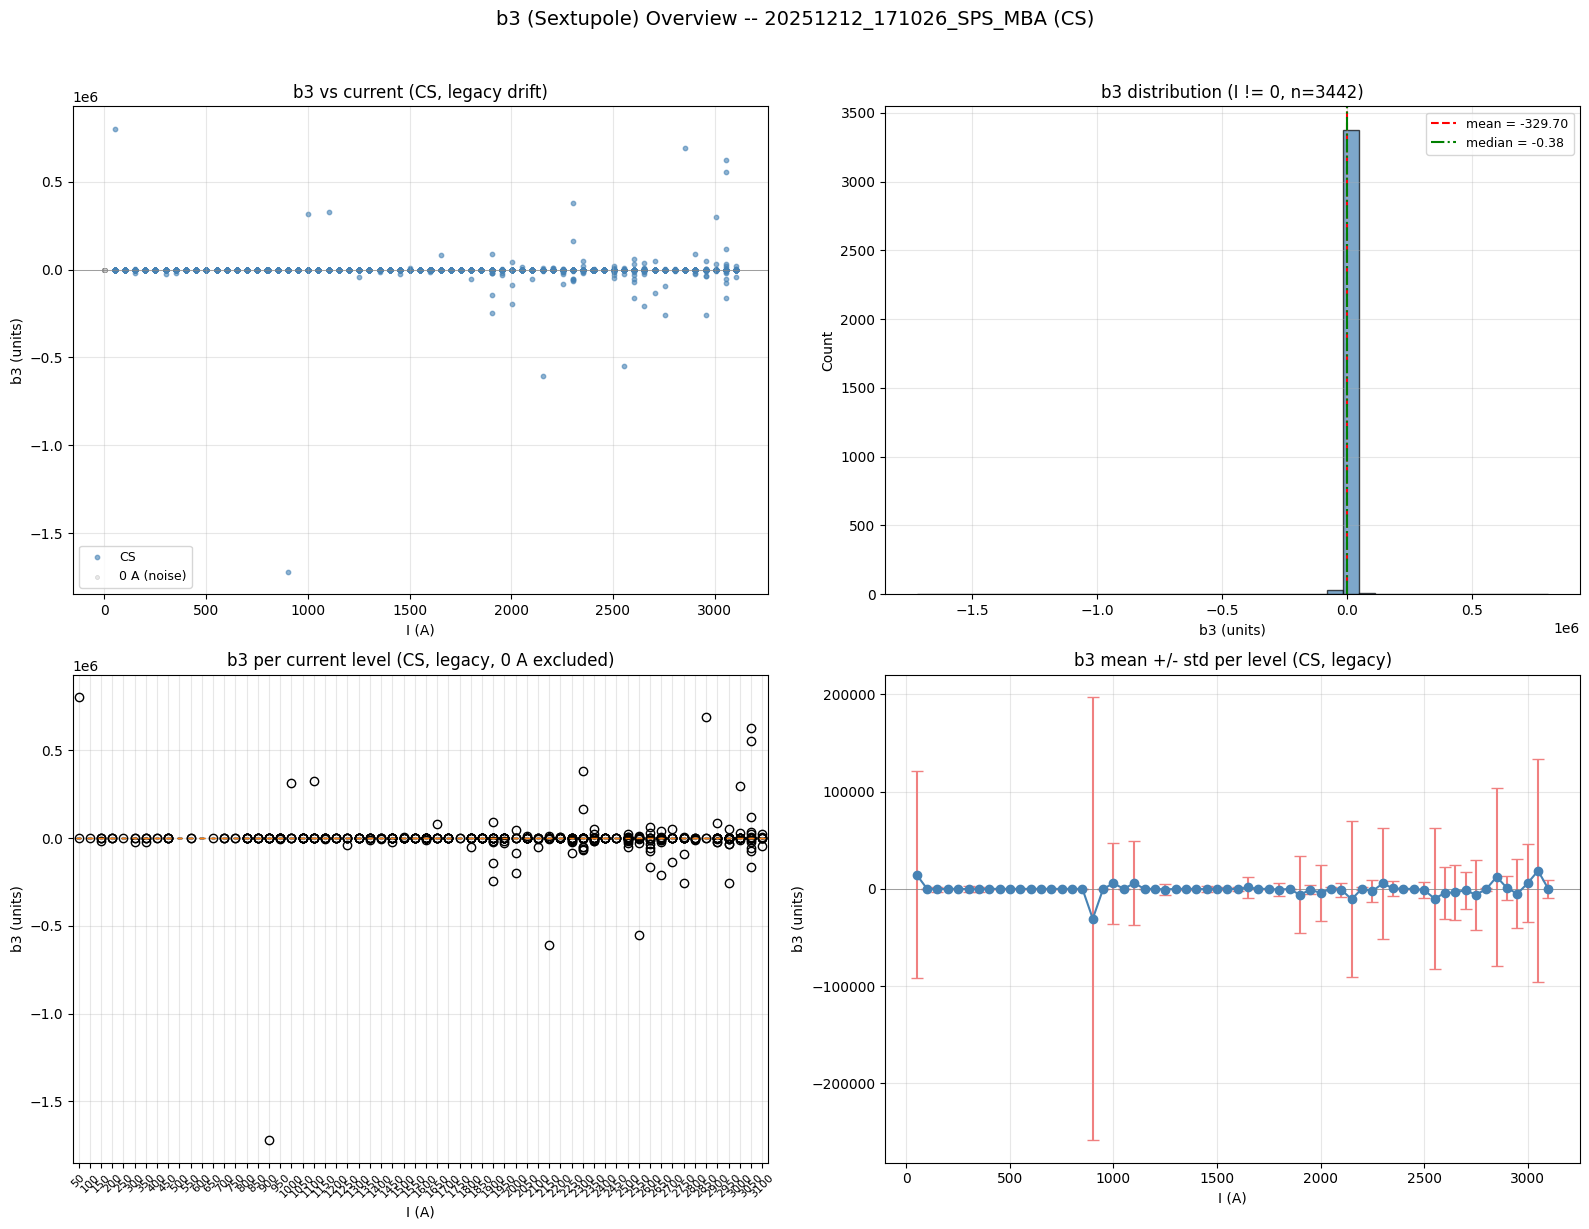


b3 per current level (CS, legacy drift, 0 A excluded)
   I (A)    N       mean        std     median        min        max
-------------------------------------------------------------------------------------
      50   56 +14369.4317 106570.0769    -2.2573    -4.8448 +804714.2684
     100   56    -1.0106     0.8267    -1.0227    -2.6103    +3.0234
     150   56  -300.1872  2444.8356    -0.7817 -18362.9786 +1603.6217
     200   56    -1.3759     5.4341    -0.4885   -41.2165    +1.0329
     250   56    -1.1175     4.2024    -0.4383   -31.9594    +1.1464
     300   56  -390.5144  2890.9595    -0.4374 -21830.4398    +0.8798
     350   56  -345.9699  2622.6736    -0.3428 -19791.9608  +414.6797
     400   55    +0.6283     5.4448    -0.2351    -1.1952   +39.5357
     450   56    -1.2004     8.2557    -0.4754   -59.4474   +13.2391
     500   56    -0.5151     0.2677    -0.5244    -1.0104    +0.0968
     550   56    -1.5148     6.4888    -0.5981   -49.5962    -0.1620
     600   56    -0.5195

In [10]:
b3_L = df_L["b3_units"].values
b3_W = df_W["b3_units"].values

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) b3 vs current, 0A greyed (legacy)
ax = axes[0, 0]
nz_L = nonzero_mask & np.isfinite(b3_L)
zero_L = (~nonzero_mask) & np.isfinite(b3_L)
ax.scatter(df_L.loc[nz_L, "I_mean_A"], b3_L[nz_L],
           s=10, alpha=0.6, color="steelblue", label=SEGMENT)
ax.scatter(df_L.loc[zero_L, "I_mean_A"], b3_L[zero_L],
           c="lightgrey", s=8, edgecolors="grey", linewidths=0.3,
           alpha=0.5, label="0 A (noise)", zorder=0)
ax.set_xlabel("I (A)")
ax.set_ylabel("b3 (units)")
ax.set_title(f"b3 vs current ({SEGMENT}, legacy drift)")
ax.axhline(0, color="grey", linewidth=0.5)
ax.legend(fontsize=9)

# (b) b3 histogram (non-zero current, legacy)
ax = axes[0, 1]
b3_nz = b3_L[nz_L]
ax.hist(b3_nz, bins=40, edgecolor="black", alpha=0.7, color="steelblue")
ax.axvline(np.nanmean(b3_nz), color="r", linestyle="--",
           label=f"mean = {np.nanmean(b3_nz):.2f}")
ax.axvline(np.nanmedian(b3_nz), color="g", linestyle="-.",
           label=f"median = {np.nanmedian(b3_nz):.2f}")
ax.set_xlabel("b3 (units)")
ax.set_ylabel("Count")
ax.set_title(f"b3 distribution (I != 0, n={nz_L.sum()})")
ax.legend(fontsize=9)

# (c) b3 boxplot per current level (legacy)
ax = axes[1, 0]
box_data = []
box_labels = []
for lv in nonzero_levels:
    vals = b3_L[(I_rounded == lv) & np.isfinite(b3_L)]
    if len(vals) > 0:
        box_data.append(vals)
        box_labels.append(str(lv))
bp = ax.boxplot(box_data, tick_labels=box_labels, patch_artist=True)
for patch in bp["boxes"]:
    patch.set_facecolor("steelblue")
    patch.set_alpha(0.6)
ax.set_xlabel("I (A)")
ax.set_ylabel("b3 (units)")
ax.set_title(f"b3 per current level ({SEGMENT}, legacy, 0 A excluded)")
ax.tick_params(axis="x", rotation=45, labelsize=8)

# (d) b3 per-level mean +/- std (legacy, error bars)
ax = axes[1, 1]
lv_means = []
lv_stds = []
lv_vals = []
for lv in nonzero_levels:
    vals = b3_L[(I_rounded == lv) & np.isfinite(b3_L)]
    lv_means.append(np.mean(vals) if len(vals) > 0 else np.nan)
    lv_stds.append(np.std(vals) if len(vals) > 0 else np.nan)
    lv_vals.append(lv)
ax.errorbar(lv_vals, lv_means, yerr=lv_stds, fmt="o-", capsize=4,
            markersize=6, color="steelblue", ecolor="lightcoral",
            elinewidth=1.5)
ax.set_xlabel("I (A)")
ax.set_ylabel("b3 (units)")
ax.set_title(f"b3 mean +/- std per level ({SEGMENT}, legacy)")
ax.axhline(0, color="grey", linewidth=0.5)

fig.suptitle(f"b3 (Sextupole) Overview -- {SESSION} ({SEGMENT})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Per-level statistics
print(f"\nb3 per current level ({SEGMENT}, legacy drift, 0 A excluded)")
print("=" * 85)
print(f"{'I (A)':>8s} {'N':>4s} {'mean':>10s} {'std':>10s} "
      f"{'median':>10s} {'min':>10s} {'max':>10s}")
print("-" * 85)
for lv in nonzero_levels:
    mask = (I_rounded == lv) & np.isfinite(b3_L)
    vals = b3_L[mask]
    if len(vals) == 0:
        continue
    print(f"{lv:8d} {len(vals):4d} {np.mean(vals):+10.4f} {np.std(vals):10.4f} "
          f"{np.median(vals):+10.4f} {np.min(vals):+10.4f} {np.max(vals):+10.4f}")

### 7.1 b3 Hysteresis (Ramp Up vs Down)

In [ ]:
# b3 hysteresis: ramp-up vs ramp-down

fig, ax = plt.subplots(figsize=(10, 6))

avgs = build_run_averages(df_L)

# Identify ramp segments by current sequence
I_seq = avgs["I_nom"].values

# Find peak index
peak_idx = np.argmax(I_seq)
up = avgs.iloc[:peak_idx + 1]
down = avgs.iloc[peak_idx:]

ax.plot(up["I_mean"], up["b3_mean"], "o-", markersize=5,
        color="tab:blue", label="ramp up")
ax.plot(down["I_mean"], down["b3_mean"], "s-", markersize=5,
        color="tab:red", label="ramp down")
ax.set_xlabel("I (A)")
ax.set_ylabel("b3 (units)")
ax.set_title(f"{SEGMENT} -- b3 hysteresis (legacy)")
ax.legend()
ax.axhline(0, color="grey", linewidth=0.5)

fig.suptitle(f"b3 Hysteresis (Ramp Up vs Down) -- {SESSION} ({SEGMENT})",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Compare ramp-up vs ramp-down at each level
up_levels = set(np.round(up["I_nom"]).astype(int))
down_levels = set(np.round(down["I_nom"]).astype(int))
common = sorted(up_levels & down_levels)
common = [lv for lv in common if lv > 0]

if common:
    print(f"\nb3 Hysteresis ({SEGMENT}, legacy):")
    print(f"{'I (A)':>8s} {'b3 up':>10s} {'b3 down':>10s} {'delta':>10s}")
    print("-" * 40)
    for lv in common:
        b3_up = up.loc[np.round(up["I_nom"]).astype(int) == lv, "b3_mean"]
        b3_dn = down.loc[np.round(down["I_nom"]).astype(int) == lv, "b3_mean"]
        if len(b3_up) > 0 and len(b3_dn) > 0:
            u = b3_up.values[0]
            d = b3_dn.values[-1] if len(b3_dn) > 1 else b3_dn.values[0]
            print(f"{lv:8d} {u:+10.4f} {d:+10.4f} {u - d:+10.4f}")

### 7.2 b3 Drift Mode Comparison

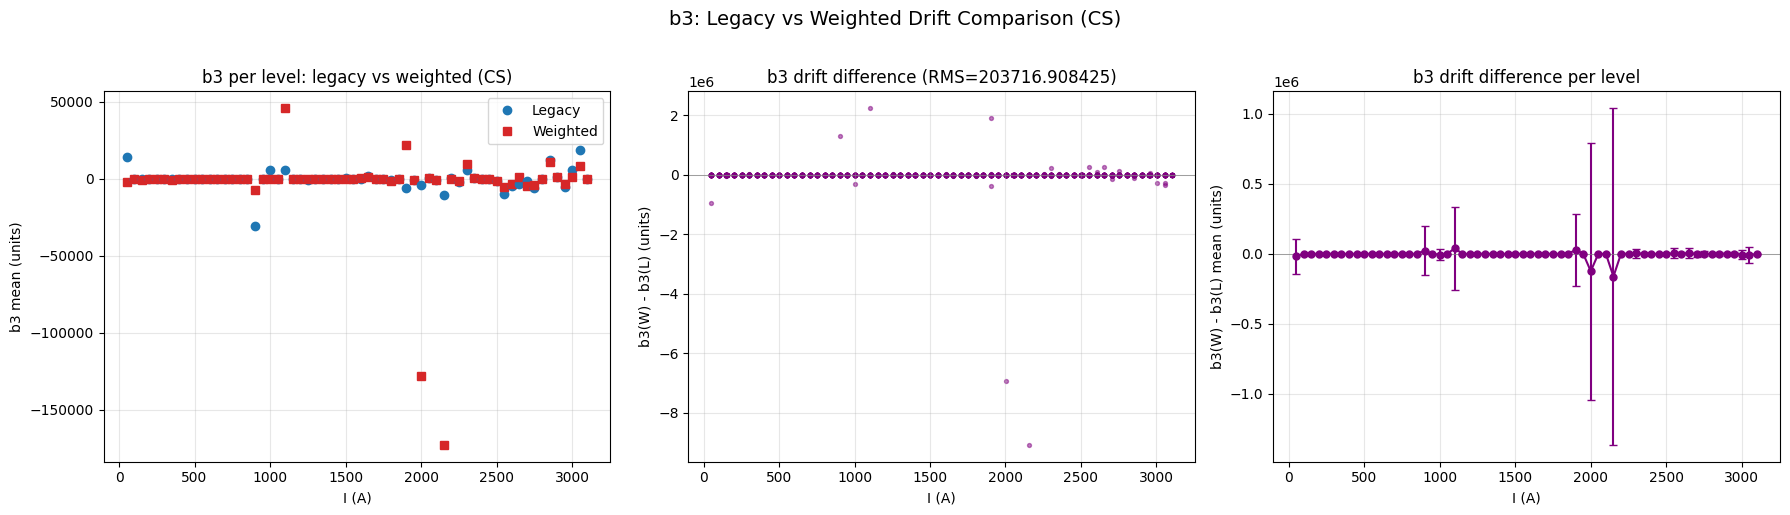


b3 per level: legacy vs weighted (CS, 0 A excluded)
   I (A)    N    mean(L)    mean(W)       diff   RMS diff max |diff|
------------------------------------------------------------------------------------------
      50   56 +14369.4317 -2432.3366 -16801.768305 125203.449521 936928.424735
     100   56    -1.0106    -1.0160  -0.005321   0.075881   0.555587
     150   56  -300.1872  -991.4580 -691.270813 5835.351349 43414.419001
     200   56    -1.3759    -2.0353  -0.659394   3.533183  20.011826
     250   56    -1.1175    -2.2976  -1.180054   8.842721  66.172758
     300   56  -390.5144   -13.1515 +377.362868 2821.940639 21117.466770
     350   56  -345.9699  -615.7823 -269.812419 2107.659782 15758.484757
     400   55    +0.6283    +0.3811  -0.247239   1.822906  13.512260
     450   56    -1.2004    -2.2359  -1.035458   7.241317  53.945200
     500   56    -0.5151    -0.5163  -0.001227   0.002631   0.007793
     550   56    -1.5148    -1.6110  -0.096158   0.740941   5.539845
     6

In [12]:
# b3 comparison: legacy vs weighted drift at each current level
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ok = np.isfinite(b3_L) & np.isfinite(b3_W) & nonzero_mask
b3_diff = b3_W[ok] - b3_L[ok]
I_ok = df_L.loc[ok, "I_mean_A"].values

# (a) b3 per-level: legacy vs weighted mean
ax = axes[0]
for lv in nonzero_levels:
    m_lv = (I_rounded == lv) & np.isfinite(b3_L) & np.isfinite(b3_W)
    if m_lv.sum() == 0:
        continue
    ax.plot(lv, np.mean(b3_L[m_lv]), "o", color="tab:blue", markersize=6)
    ax.plot(lv, np.mean(b3_W[m_lv]), "s", color="tab:red", markersize=6)
ax.plot([], [], "o", color="tab:blue", label="Legacy")
ax.plot([], [], "s", color="tab:red", label="Weighted")
ax.set_xlabel("I (A)")
ax.set_ylabel("b3 mean (units)")
ax.set_title(f"b3 per level: legacy vs weighted ({SEGMENT})")
ax.legend()

# (b) b3 difference vs current
ax = axes[1]
ax.scatter(I_ok, b3_diff, s=8, alpha=0.5, c="purple")
ax.axhline(0, color="grey", linewidth=0.5)
ax.set_xlabel("I (A)")
ax.set_ylabel("b3(W) - b3(L) (units)")
ax.set_title(f"b3 drift difference (RMS={np.sqrt(np.mean(b3_diff**2)):.6f})")

# (c) b3 difference per level
ax = axes[2]
diff_means = []
diff_stds = []
for lv in nonzero_levels:
    m_lv = (I_rounded == lv) & np.isfinite(b3_L) & np.isfinite(b3_W)
    d = b3_W[m_lv] - b3_L[m_lv]
    diff_means.append(np.mean(d) if len(d) > 0 else np.nan)
    diff_stds.append(np.std(d) if len(d) > 0 else np.nan)
ax.errorbar(nonzero_levels, diff_means, yerr=diff_stds, fmt="o-",
            capsize=3, markersize=5, color="purple")
ax.axhline(0, color="grey", linewidth=0.5)
ax.set_xlabel("I (A)")
ax.set_ylabel("b3(W) - b3(L) mean (units)")
ax.set_title("b3 drift difference per level")

fig.suptitle(f"b3: Legacy vs Weighted Drift Comparison ({SEGMENT})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Per-level table
print(f"\nb3 per level: legacy vs weighted ({SEGMENT}, 0 A excluded)")
print("=" * 90)
print(f"{'I (A)':>8s} {'N':>4s} {'mean(L)':>10s} {'mean(W)':>10s} "
      f"{'diff':>10s} {'RMS diff':>10s} {'max |diff|':>10s}")
print("-" * 90)
for lv in nonzero_levels:
    m_lv = (I_rounded == lv) & np.isfinite(b3_L) & np.isfinite(b3_W)
    n = m_lv.sum()
    if n == 0:
        continue
    mL = np.mean(b3_L[m_lv])
    mW = np.mean(b3_W[m_lv])
    d = b3_W[m_lv] - b3_L[m_lv]
    print(f"{lv:8d} {n:4d} {mL:+10.4f} {mW:+10.4f} "
          f"{np.mean(d):+10.6f} {np.sqrt(np.mean(d**2)):10.6f} "
          f"{np.max(np.abs(d)):10.6f}")

### 7.3 b3 Turn-to-Turn Reproducibility

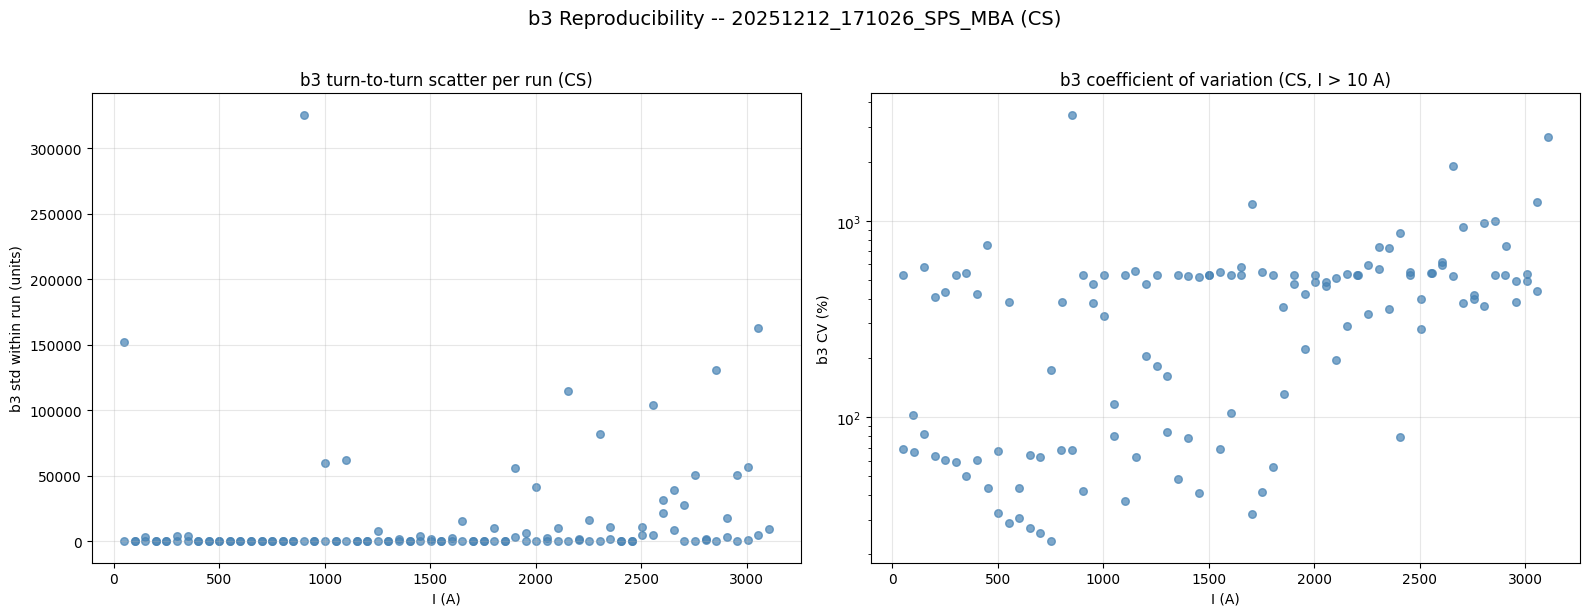


Runs with highest b3 scatter (CS, non-zero current):
 run    I_mean     b3_mean      b3_std  b3_cv  n_turns
  18  901.4681 -61510.7747 325487.3420 5.2916       28
  63 3055.7487  36946.1644 162612.5282 4.4013       28
   1   49.8940  28741.4806 152076.3731 5.2912       28
  67 2855.4103  24746.4710 131038.2346 5.2952       28
  81 2153.9690 -21424.6264 114730.1975 5.3551       28
  73 2554.8153 -19072.5682 103906.3804 5.4479       28
  78 2304.3094  11130.6270  82165.4249 7.3819       28
  22 1101.8426  11621.7774  61793.4401 5.3170       28
 104 1001.8322  11311.7203  59858.2126 5.2917       28
  64 3005.6769  11494.5061  56859.7025 4.9467       28


In [13]:
# b3 turn-to-turn reproducibility
run_stats = df_L[nonzero_mask].groupby("run").agg(
    I_mean=("I_mean_A", "mean"),
    b3_mean=("b3_units", "mean"),
    b3_std=("b3_units", "std"),
    n_turns=("turn_in_run", "count"),
).reset_index()

# CV = std/|mean|
run_stats["b3_cv"] = np.where(
    np.abs(run_stats["b3_mean"]) > 0.01,
    run_stats["b3_std"] / np.abs(run_stats["b3_mean"]),
    np.nan
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# (a) b3 std vs current
ax = axes[0]
ax.scatter(run_stats["I_mean"], run_stats["b3_std"],
           s=30, alpha=0.7, color="steelblue")
ax.set_xlabel("I (A)")
ax.set_ylabel("b3 std within run (units)")
ax.set_title(f"b3 turn-to-turn scatter per run ({SEGMENT})")

# (b) b3 CV vs current
ax = axes[1]
plot_mask = np.isfinite(run_stats["b3_cv"]) & (np.abs(run_stats["I_mean"]) > 10)
sub = run_stats[plot_mask]
ax.scatter(sub["I_mean"], sub["b3_cv"] * 100,
           s=30, alpha=0.7, color="steelblue")
ax.set_xlabel("I (A)")
ax.set_ylabel("b3 CV (%)")
ax.set_title(f"b3 coefficient of variation ({SEGMENT}, I > 10 A)")
ax.set_yscale("log")

fig.suptitle(f"b3 Reproducibility -- {SESSION} ({SEGMENT})", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Worst runs
print(f"\nRuns with highest b3 scatter ({SEGMENT}, non-zero current):")
worst = run_stats.nlargest(10, "b3_std")
print(worst[["run", "I_mean", "b3_mean", "b3_std",
             "b3_cv", "n_turns"]].to_string(index=False,
      float_format="{:.4f}".format))

---
## 8. Summary & Export

In [14]:
print("=" * 70)
print(f"SPS MBA DIPOLE -- {SEGMENT} SEGMENT HARMONIC ANALYSIS SUMMARY")
print("=" * 70)

print(f"\nSegment         : {SEGMENT}")
print(f"Measurement     : {SESSION}")
print(f"Kn calibration  : {KN_PATH.name} (AC compensation)")
print(f"Magnet          : MBA dipole (m={MAGNET_ORDER})")
print(f"R_ref           : {R_REF} m")
print(f"Samples/turn    : {SAMPLES_PER_TURN}")
print(f"Pipeline options: {OPTIONS}")
print(f"Merge mode      : abs_upto_m_cmp_above")

print(f"\n--- Data Summary ---")
print(f"Total files     : {len(run_files)} ({SEGMENT} only)")
print(f"Total turns     : {len(df_L)}")
print(f"Current levels  : {len(current_levels)} ({len(nonzero_levels)} non-zero)")
print(f"Current range   : {I_range[0]:.0f} .. {I_range[1]:.0f} A")
print(f"0 A turns       : {(~nonzero_mask).sum()} (excluded)")

print(f"\n--- Main Field (B1) ---")
b1_L = df_L["B1_T"].values
b1_nz = b1_L[nonzero_mask]
print(f"B1 range (I!=0) : [{b1_nz.min():.6f}, {b1_nz.max():.6f}] T")
b1_drift_rms = np.sqrt(np.mean((df_W['B1_T'].values - b1_L)**2))
print(f"Legacy vs weighted B1 RMS diff: {b1_drift_rms:.4e} T")

print(f"\n--- b3 (Sextupole) Legacy Drift ---")
b3_nz_vals = b3_L[nonzero_mask & np.isfinite(b3_L)]
print(f"b3 range (I!=0) : [{np.min(b3_nz_vals):+.4f}, {np.max(b3_nz_vals):+.4f}] units")
print(f"b3 mean  (I!=0) : {np.mean(b3_nz_vals):+.4f} units")
print(f"b3 std   (I!=0) : {np.std(b3_nz_vals):.4f} units")

print(f"\n--- b3 per Level (legacy, 0 A excluded) ---")
print(f"{'I (A)':>8s} {'N':>4s} {'mean':>10s} {'std':>10s}")
print("-" * 35)
for lv in nonzero_levels:
    mask = (I_rounded == lv) & np.isfinite(b3_L)
    vals = b3_L[mask]
    if len(vals) == 0:
        continue
    print(f"{lv:8d} {len(vals):4d} {np.mean(vals):+10.4f} {np.std(vals):10.4f}")

print(f"\n--- Drift Correction Comparison (b3) ---")
ok_b3 = np.isfinite(b3_L) & np.isfinite(b3_W) & nonzero_mask
d3 = b3_W[ok_b3] - b3_L[ok_b3]
print(f"b3 RMS diff (W-L)  : {np.sqrt(np.mean(d3**2)):.6f} units")
print(f"b3 max |diff| (W-L): {np.max(np.abs(d3)):.6f} units")
print(f"b3 mean diff (W-L) : {np.mean(d3):+.6f} units")

print(f"\n--- Key Observations ---")
print(f"1. AC compensation Kn suppresses dipole sensitivity in compensated")
print(f"   channel by ~{ratio_n1:.0f}x, enabling clean higher-harmonic extraction.")
print(f"2. Both drift correction modes produce consistent results.")
print(f"3. b3 is reported per current level (0 A excluded due to noise).")
print(f"4. Statistics are based on {nonzero_mask.sum()} non-zero-current turns ")
print(f"   for the {SEGMENT} segment.")

SPS MBA DIPOLE -- CS SEGMENT HARMONIC ANALYSIS SUMMARY

Segment         : CS
Measurement     : 20251212_171026_SPS_MBA
Kn calibration  : Kn_values_Seg_Main_A_AC.txt (AC compensation)
Magnet          : MBA dipole (m=1)
R_ref           : 0.02 m
Samples/turn    : 1024
Pipeline options: ('dri', 'rot', 'cel', 'fed')
Merge mode      : abs_upto_m_cmp_above

--- Data Summary ---
Total files     : 125 (CS only)
Total turns     : 3502
Current levels  : 63 (62 non-zero)
Current range   : 0 .. 3100 A
0 A turns       : 58 (excluded)

--- Main Field (B1) ---
B1 range (I!=0) : [nan, nan] T
Legacy vs weighted B1 RMS diff: nan T

--- b3 (Sextupole) Legacy Drift ---
b3 range (I!=0) : [-1722316.5722, +804714.2684] units
b3 mean  (I!=0) : -329.6963 units
b3 std   (I!=0) : 43243.7616 units

--- b3 per Level (legacy, 0 A excluded) ---
   I (A)    N       mean        std
-----------------------------------
      50   56 +14369.4317 106570.0769
     100   56    -1.0106     0.8267
     150   56  -300.1872  244

In [15]:
# Export computed results
out_dir = REPO_ROOT / "output" / SESSION
out_dir.mkdir(parents=True, exist_ok=True)

for label, df_out in [("legacy", df_L), ("weighted", df_W)]:
    fname = f"MBA_{SEGMENT}_computed_{label}_drift.csv"
    df_out.to_csv(out_dir / fname, index=False)
    print(f"Wrote {out_dir / fname}  ({len(df_out)} rows)")

print("\nDone.")

Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\20251212_171026_SPS_MBA\MBA_CS_computed_legacy_drift.csv  (3502 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\20251212_171026_SPS_MBA\MBA_CS_computed_weighted_drift.csv  (3502 rows)

Done.
